# 2.2.2 Definición de probabilidad y sus aplicaciones: Algoritmo 1R

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

Los sistemas de inducción de reglas permiten la construcción de clasificadores sobre grandes conjuntos de datos. Estos clasificadores pueden tomarse como punto de referencia, en términos de su precisión, para la evaluación de clasificadores elaborados con otras metodologías más complejas. En este tutorial se presenta la solución de un caso real, en el que se desea determinar si un hongo es o no venenoso a partir de sus características físicas.

## Descripción del problema

Se desea determinar si un hongo es comestible o no a partir de sus características físicas. Para ello, se tiene una muestra de 8124 instancias de hongos provenientes de 23 especies de la familia Agaricus y Lepiota, los cuales han sido clasificados como comestibles, venenosos o de comestibilidad indeterminada. Se desea construir un sistema de clasificación que permita determinar si un hongo puede ser comestible o no. Por el tipo de problema en cuestión, los hongos de comestibilidad indeterminada fueron asignados a la clase de hongos definitivamente venenosos, ya que no se puede correr el riesgo de dar un hongo potencialmente venenoso a una persona para su consumo.

La información contenida en la muestra es la siguiente:

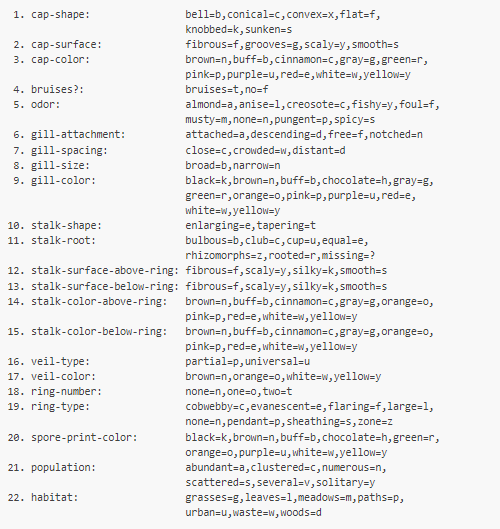

Para este ejemplo, se usa la información decrita en:

https://archive.ics.uci.edu/ml/datasets/mushroom

Las siguientes reglas han sido establecidas como el benchmark para este dataset:

P_1) odor=NOT(almond.OR.anise.OR.none)
     120 poisonous cases missed, 98.52% accuracy

P_2) spore-print-color=green
     48 cases missed, 99.41% accuracy

P_3) odor=none.AND.stalk-surface-below-ring=scaly.AND.
         (stalk-color-above-ring=NOT.brown)
     8 cases missed, 99.90% accuracy

P_4) habitat=leaves.AND.cap-color=white
         100% accuracy

La regla P_4 también podría ser especificada como:

P_4') population=clustered.AND.cap_color=white

### Preparación

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
##
## Leer el archivo.
##

# URL del dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

# Nombres de las columnas del dataset
column_names = [
    "class", "cap_shape", "cap_surface", "cap_color", "bruises", "odor",
    "gill_attachment", "gill_spacing", "gill_size", "gill_color", "stalk_shape",
    "stalk_root", "stalk_surface_above_ring", "stalk_surface_below_ring",
    "stalk_color_above_ring", "stalk_color_below_ring", "veil_type", "veil_color",
    "ring_number", "ring_type", "spore_print_color", "population", "habitat"
]

df = pd.read_csv(
    url,
    header=None,       # sin cabecera 
    names=column_names,# lista de nombres de columnas
    sep = ',',         # separador de campos
    thousands = None,  # separador de miles para números
    decimal = '.')     # separador de los decimales para números

df.head()

In [ ]:
df.tail()

In [ ]:
##
## Verifica la lectura de los datos
##
df.describe()

In [ ]:
df.info()

In [ ]:
##
## Nombres de las columnas
##
sorted(df.columns)

### Análisis Exploratorio

In [ ]:
df['class'].value_counts()

In [ ]:
df['class'].value_counts().plot.bar();

In [ ]:
#
# Cantidad de ocurrencias por atributo de cada columna
#
# La revisión que se realiza es la siguiente:
#
#   * Se verifica la cantidad de registros leídos. Ok!.
#
#   * Se buscan variables con un solo nivel. Esto significa
#     que la variable contiene un valor constante y no tiene
#     categorias para un clasificador
#
for colname in df.columns:
    # print(colname)
    print(df[colname].value_counts())
    print()

In [ ]:
#
# La columna veil_type contiene un valor constante
# y se elimina (posicion 16 iniciando en cero)
#
df.drop('veil_type', axis=1, inplace=True)

### Entrenamiento del modelo

In [ ]:
class OneR:
    def __init__(self):
        self.rules = None

    def predict(self, X):
        df0 = X.copy()
        df0 = df0.set_index(self.rules.index.name, drop=False)
        df0 = df0.join(self.rules, rsuffix="_predicted_" + self.rules.index.name)
        df0.index = range(len(df0))
        return df0.copy()

    def fit(self, df, X_cols, target_col):
        # X: pandas DataFrame con las variables de entrada
        # target: columna con las clases

        def fit_var(var):
            #
            # Ajusta el modelo para la variable `var`
            #
            df0 = df[list(X_cols) + [target_col]].copy()
            df0["counter"] = 0
            df0 = df0.groupby([var, target_col], as_index=False).count()[[var, target_col, "counter"]]
            df0_max_counter = df0.groupby([var], as_index=False).transform(max)
            df0_idx = df0["counter"] == df0_max_counter["counter"]
            df0 = df0.loc[df0_idx, [var, target_col]]
            df0 = df0.groupby(var, as_index=False).first()
            df0 = df0.set_index(var)
            return df0

        best_precision = None
        best_rules = None

        print('Reporte:')
        print('======================================')
        for column in X_cols:
            self.rules = fit_var(column)
            df0 = self.predict(df)
            current_precision = (df0[target_col] == df0[target_col + '_predicted_' + column]).sum()
            if best_precision is None or current_precision > best_precision:
                best_rules = self.rules.copy()
                best_precision = current_precision
                print("{:>12s} : {}".format(column, current_precision))

        self.rules = best_rules.copy()

In [ ]:
#
# Aplicación al caso actual
#
m = OneR()
m.fit(df, X_cols=df.columns[1:], target_col='class')
m.rules

La porción final de la salida contiene la descripción de las reglas del clasificador

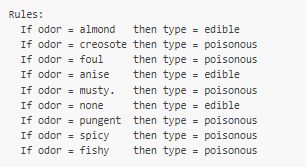

In [ ]:
#
# Precsision
#
print('Precision: {:5.2f}%'.format(8004 / 8124 * 100))

### Evaluación

In [ ]:
p = m.predict(df)
confusion_matrix(
    p['class'],
    p.class_predicted_odor,
)

In [ ]:
print('ok_')